# Zombie Model Simulation

We make use of the population density map downloaded from [GEOSTAT](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/population-distribution-demography/geostat) to model a disease spread over the iberian peninsula. 

We asume a Zombie Model similar to the SIR but in which the infected state is a zombie without posibility of recovery. We call it the SZR model.

$$ 
\begin{align}
u(t) & = \begin{pmatrix} S \\ I \\ R \end{pmatrix} & f(u)   = u'(t) = \begin{pmatrix} S' \\ I' \\ R' \end{pmatrix}  = \begin{pmatrix}
  -\beta I S  \\
  \beta I S - \gamma I  \\
 \gamma I
\end{pmatrix} 
\end{align}
$$

This is what's called a [SIR model]() where the letters S, I and R reflects different states an individual can have in a zombie outbreak:

  * $S$ for susceptible. Number of healthy individuals that potentially could turn.
  * $I$ for infected. Number of *walkers*.
  * $R$ for removed. Number of individuals that's out of the game by separation of head from body (if I know my zombie movies correctly), or that survived. But there's no cure of "zombie:ism", so let's not fool ourselves (it might be the case thou if the SIR model is used for flu epidemics).
  
We also have $\beta$ and $\gamma$:

  * $\beta$ is how transmittable the disease is. One bite is all it takes!
  * $\gamma$ is how fast you go from zombie to dead. Has to be some sort of average of how fast our zombie hunters is working... Well it's not a perfect model. Bare with me.
  
So $S' = -\beta I S$ tells us how fast people are turning into zombies. $S'$ being the time derivative.

$I' = \beta I S - \gamma I$ tells us how the infected increases and how fast the zombie workers are putting zombies in the *removed* state (pun intended).

$R' = \gamma I$ just picks up the $\gamma I$ term that was negative in the previous equation.

### Equations on a lattice

The above model does not take into account that there must be spatial distribution of S/I/R. So let's fix that!

One approach is to divide the iberian peninsula into a grid where every cell can infect the nearby. This can be described as follows:

$$
\begin{align}
 f(u)   = u'(t)  = \begin{pmatrix} S' \\ I' \\ R' \end{pmatrix} = \begin{pmatrix}
  -\beta \left(S_{i,j}I_{i,j} + S_{i-1,j}I_{i-1,j} + S_{i+1,j}I_{i+1,j} + S_{i,j-1}I_{i,j-1} + S_{i,j+1}I_{i,j+1}\right)  \\
  \beta \left(S_{i,j}I_{i,j} + S_{i-1,j}I_{i-1,j} + S_{i+1,j}I_{i+1,j} + S_{i,j-1}I_{i,j-1} + S_{i,j+1}I_{i,j+1}\right) - \gamma I_{i,j}  \\
 \gamma I_{i,j}
\end{pmatrix} 
\end{align}
$$

Where for example $S_{ij}$ being one cell and $S_{i-1j}$, $S_{i+1j}$, $S_{ij-1}$ and $S_{ij+1}$ being the surrounding cells (let's not make our brains tired with the diagonal cells, we need our brain for not getting our brain eaten).

In [2]:
import cudf
import cupy as cp

In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt    
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = 12, 8

Let's read the susceptible population grid

In [6]:
gdf = cudf.read_parquet('../data/peninsula_pop_grid.parquet')

/home/acalle/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/fsspec/implementations/local.py:33: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


In [7]:
gdf.head()

,TOT_P,East,North
0,24,944,2764
1,25,944,2765
2,44,944,2766
3,43,945,2768
4,76,946,2770


In [8]:
gdf.shape

(104945, 3)

In [9]:
gdf['East'].min(), gdf['East'].max()

(944, 3831)

In [10]:
gdf['North'].min(), gdf['North'].max()

(942, 2788)

Remove from the simulation all the islands:

In [20]:
gdf = gdf[gdf['East'] > 2500]

In [43]:
pdf = pd.read_parquet('../data/peninsula_pop_grid.parquet')

In [44]:
pdf = pdf[(pdf['East'] > 2500) & (pdf['North'] > 1570)]

In [46]:
pdf['North'] = pdf['North'] - pdf['North'].min()
pdf['East'] = pdf['East'] - pdf['East'].min()

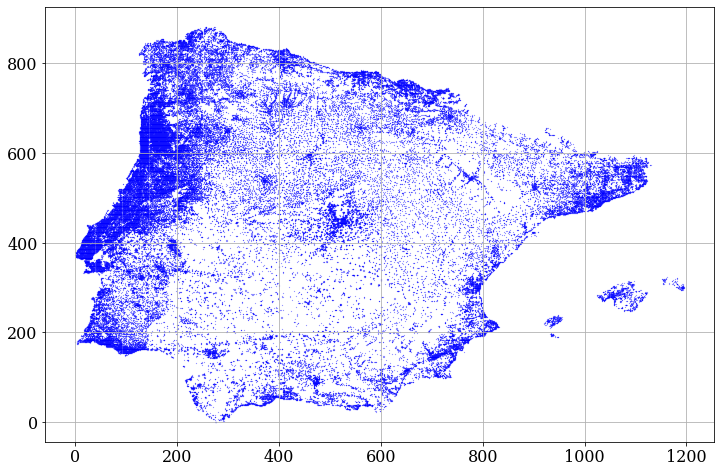

In [53]:
plt.scatter(pdf['East'], pdf['North'], c='blue', marker='.', s=0.1)
plt.grid(which='both')

In [54]:
pdf['North'].min(), pdf['North'].max()

(0, 882)

In [55]:
pdf['East'].min(), pdf['East'].max()

(0, 1195)

We build a 1200x1200 matrix which will represent our population grid

In [91]:
N = 1200
S = np.zeros(N*N)

In [92]:
S.shape

(1440000,)

In [95]:
# Pandas apply
def xy2ind(n, x, y):
    """
    returns the S matrix index given x, y population grid coordinates.
    assumes 0-based indexing
    """
    return x + n * y

In [97]:
%%time 
for index, row in pdf.iterrows():
    S[xy2ind(N, row['East'], row['North'])] = row['TOT_P']

CPU times: user 8.89 s, sys: 0 ns, total: 8.89 s
Wall time: 8.89 s


In [154]:
S2 = S.reshape((N,N))
#S2 = np.flip(S2, 0)
S2 = S2[:900, :]

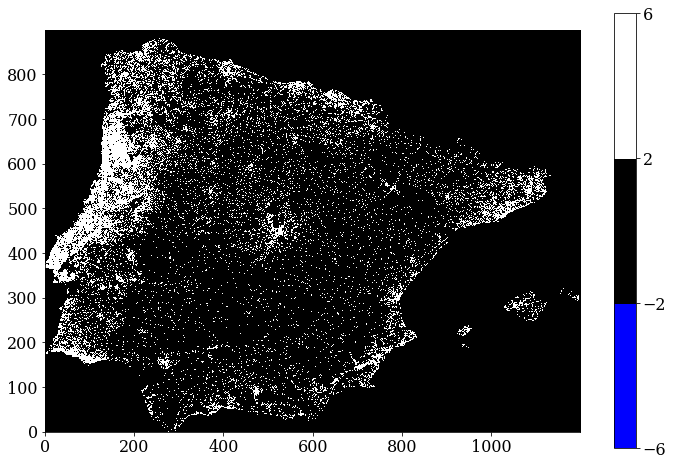

In [155]:
import matplotlib as mpl
from matplotlib import pyplot

cmap = mpl.colors.ListedColormap(['blue','black','white'])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

img = pyplot.imshow(S2, interpolation='nearest',
                    cmap=cmap,
                    norm=norm,
                    origin='lower')

# make a color bar
pyplot.colorbar(img,cmap=cmap)

pyplot.show()

Some appropriate beta and gamma making sure to wipe out most of the country.

In [169]:
beta = 0.010
gamma = 1

Remember the definition of a derivative? With some rearranging it can actually be used to approximate  the next step of the function when the derivative is known and $\Delta t$ is assumed to be small. And we have already stated $u'(t)$.

$$ 
u'(t) = \mathop {\lim }\limits_{\Delta t \to 0} \frac{ {u\left( {t + \Delta t } \right) - u\left( t \right)}}{\Delta t}  $$ 

$$ 
u' \Delta t + u\left( t \right)= {u\left( {t + \Delta t } \right)}  $$ 

Remember from before

$$  f(u)   = u'(t)$$

And let's call $u\left( {t + \Delta t } \right)$ which is the function $u$ in the next time step for $u_{n+1}$, and $u(t) = u_n$ which is the current time step.

$$  u_{n+1} = f(u)\Delta t + u_n  $$

This is called [the Euler method](http://en.wikipedia.org/wiki/Euler_method). Let's write it in code:

In [163]:
def euler_step(u, f, dt):
    return u + dt * f(u)

We also need $f(u)$ in code. This uses some nifty array operations by the goodness of numpy. I just might get back to that in another blog post, because they're great and might need some more explaining. But for now this will do.

$$
\begin{align}
 f(u)   = u'(t)  = \begin{pmatrix} S' \\ I' \\ R' \end{pmatrix} = \begin{pmatrix}
  -\beta \left(S_{i,j}I_{i,j} + S_{i-1,j}I_{i-1,j} + S_{i+1,j}I_{i+1,j} + S_{i,j-1}I_{i,j-1} + S_{i,j+1}I_{i,j+1}\right)  \\
  \beta \left(S_{i,j}I_{i,j} + S_{i-1,j}I_{i-1,j} + S_{i+1,j}I_{i+1,j} + S_{i,j-1}I_{i,j-1} + S_{i,j+1}I_{i,j+1}\right) - \gamma I_{i,j}  \\
 \gamma I_{i,j}
\end{pmatrix} 
\end{align}
$$

In [165]:
def f(u):
    
    S = u[0]
    I = u[1]
    R = u[2]
    
    new = np.array([-beta*( S[1:-1, 1:-1]*I[1:-1, 1:-1] + \
                            S[0:-2, 1:-1]*I[0:-2, 1:-1] + \
                            S[2:, 1:-1]*I[2:, 1:-1] + \
                            S[1:-1, 0:-2]*I[1:-1, 0:-2] + \
                            S[1:-1, 2:]*I[1:-1, 2:]),
                     beta*( S[1:-1, 1:-1]*I[1:-1, 1:-1] + \
                            S[0:-2, 1:-1]*I[0:-2, 1:-1] + \
                            S[2:, 1:-1]*I[2:, 1:-1] + \
                            S[1:-1, 0:-2]*I[1:-1, 0:-2] + \
                            S[1:-1, 2:]*I[1:-1, 2:]) - gamma*I[1:-1, 1:-1],
                     gamma*I[1:-1, 1:-1]
                    ])
    
    padding = np.zeros_like(u)
    padding[:,1:-1,1:-1] = new
    
    #padding[0][padding[0] < 0] = 0
    #padding[0][padding[0] > 255] = 255
    #padding[1][padding[1] < 0] = 0
    #padding[1][padding[1] > 255] = 255
    #padding[2][padding[2] < 0] = 0
    #padding[2][padding[2] > 255] = 255
    
    return padding

###### Population density in the iberian peninsula

Our $S$ matrix, the susceptible individuals should be something like the population density. The infected $I$ is for now just zeros. But let's put a patient zero somewhere in Madrid.

In [156]:
S_0 = S2
I_0 = np.zeros_like(S_0)
I_0[500,450] = 1 # patient zero

Nobodys dead, yet. So lets put $R$ to zeroes too.

In [157]:
R_0 = np.zeros_like(S_0)

Now set some initial values of how long the simulation is to be run and so on.

In [166]:
T = 900                         # final time
dt = 1                          # time increment
N = int(T/dt) + 1               # number of time-steps
t = np.linspace(0.0, T, N)      # time discretization

# initialize the array containing the solution for each time-step
u = np.empty((N, 3, S_0.shape[0], S_0.shape[1]))
u[0][0] = S_0
u[0][1] = I_0
u[0][2] = R_0

We need to make a custom colormap so that the infected matrix can be overlayed on the map.

In [167]:
import matplotlib.cm as cm
theCM = cm.get_cmap("Reds")
theCM._init()
alphas = np.abs(np.linspace(0, 1, theCM.N))
theCM._lut[:-3,-1] = alphas

And we sit back and enjoy...

In [170]:
for n in range(N-1):
    u[n+1] = euler_step(u[n], f, dt)

In [172]:
u[100, 1, :, :]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Not let's render some images and make a gif of it. Everybody loves gifs!

In [ ]:
#from images2gif import writeGif

keyFrames = []
frames = 60.0

for i in range(0, N-1, int(N/frames)):
    imgplot = plt.imshow(S2, vmin=0, vmax=255)
    imgplot.set_interpolation("nearest")
    imgplot = plt.imshow(u[i][1], vmin=0, cmap=theCM)
    imgplot.set_interpolation("nearest")
    #filename = "outbreak" + str(i) + ".png"
    #plt.savefig(filename)
    #keyFrames.append(filename)
  
#images = [Image.open(fn) for fn in keyFrames]
#gifFilename = "outbreak.gif"
#writeGif(gifFilename, images, duration=0.3)
#plt.clf()

![alt text](outbreak.gif "Title")

###### The spread of infection as a gif. Even the Finns will succumb.

Look at that! The only safe place seem to be in the northern parts where it's not so densly populated. Even Finland will at the end of the animation be infected. Now you know.

If you want to know more about solving differential equations I can warmly recommend [Practical Numerical Methods with Python](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about) by [@LorenaABarba](https://twitter.com/LorenaABarba). Here you'll learn all the real numerical methods that should be used instead of the simple one in this post.

**UPDATE**: To play around for yourself, the Ipython notebook can be found [here](https://github.com/maxberggren/blog-notebooks/blob/master/SweEbola.ipynb).